# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

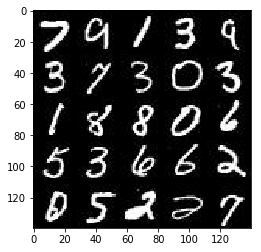

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

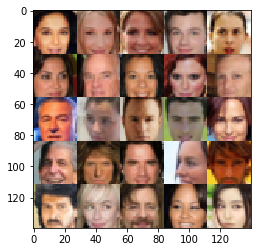

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None,image_width,image_height,image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate=tf.placeholder(tf.float32,name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten image
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        logits=tf.image.resize_images(logits,[28,28])
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars =tf.trainable_variables()
    d_vars =[var for var in t_vars if var.name.startswith('discriminator')]
    g_vars =[var for var in t_vars if var.name.startswith('generator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_t_opt= tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_t_opt= tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_t_opt, g_t_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    in_real,in_z,lr=model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    d_loss,g_loss=model_loss(in_real,in_z,data_shape[3])
    d_t_opt,g_t_opt=model_opt(d_loss,g_loss,learning_rate,beta1)
    
    steps = 0
    print_every=10
    show_every=100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_t_opt, feed_dict={in_real: batch_images,in_z: batch_z,lr:learning_rate})
                _ = sess.run(g_t_opt, feed_dict={in_real: batch_images,in_z: batch_z,lr:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({in_z: batch_z, in_real: batch_images})
                    train_loss_g = g_loss.eval({in_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 20, in_z, data_shape[3], data_image_mode)                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0658... Generator Loss: 4.0239
Epoch 1/2... Discriminator Loss: 0.3103... Generator Loss: 1.4809
Epoch 1/2... Discriminator Loss: 0.2487... Generator Loss: 1.7835
Epoch 1/2... Discriminator Loss: 0.1450... Generator Loss: 5.0822
Epoch 1/2... Discriminator Loss: 0.4573... Generator Loss: 11.3368
Epoch 1/2... Discriminator Loss: 0.6352... Generator Loss: 1.5242
Epoch 1/2... Discriminator Loss: 0.5490... Generator Loss: 2.9516
Epoch 1/2... Discriminator Loss: 1.0785... Generator Loss: 0.8517
Epoch 1/2... Discriminator Loss: 0.5888... Generator Loss: 3.5805
Epoch 1/2... Discriminator Loss: 0.6564... Generator Loss: 1.1515


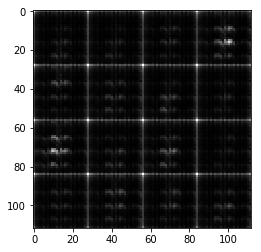

Epoch 1/2... Discriminator Loss: 0.8448... Generator Loss: 0.9996
Epoch 1/2... Discriminator Loss: 0.4993... Generator Loss: 1.2401
Epoch 1/2... Discriminator Loss: 0.4286... Generator Loss: 1.6633
Epoch 1/2... Discriminator Loss: 0.4046... Generator Loss: 2.8022
Epoch 1/2... Discriminator Loss: 0.9067... Generator Loss: 0.7560
Epoch 1/2... Discriminator Loss: 0.6188... Generator Loss: 1.3963
Epoch 1/2... Discriminator Loss: 0.4853... Generator Loss: 2.0805
Epoch 1/2... Discriminator Loss: 0.7198... Generator Loss: 1.0242
Epoch 1/2... Discriminator Loss: 1.1407... Generator Loss: 1.6221
Epoch 1/2... Discriminator Loss: 1.2737... Generator Loss: 0.5596


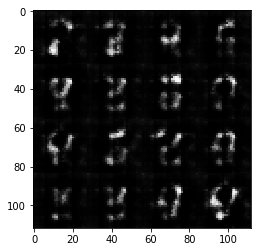

Epoch 1/2... Discriminator Loss: 0.7182... Generator Loss: 1.2411
Epoch 1/2... Discriminator Loss: 0.6620... Generator Loss: 1.9055
Epoch 1/2... Discriminator Loss: 1.5083... Generator Loss: 3.9374
Epoch 1/2... Discriminator Loss: 0.9196... Generator Loss: 1.5160
Epoch 1/2... Discriminator Loss: 0.8522... Generator Loss: 1.0100
Epoch 1/2... Discriminator Loss: 0.6215... Generator Loss: 1.4366
Epoch 1/2... Discriminator Loss: 0.5827... Generator Loss: 1.7422
Epoch 1/2... Discriminator Loss: 0.9962... Generator Loss: 2.0162
Epoch 1/2... Discriminator Loss: 0.7533... Generator Loss: 1.6757
Epoch 1/2... Discriminator Loss: 0.9667... Generator Loss: 0.8071


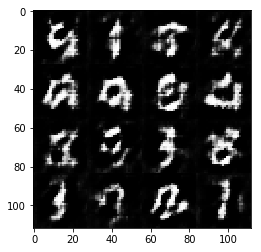

Epoch 1/2... Discriminator Loss: 0.8358... Generator Loss: 1.7815
Epoch 1/2... Discriminator Loss: 0.8671... Generator Loss: 1.1892
Epoch 1/2... Discriminator Loss: 0.6723... Generator Loss: 1.5166
Epoch 1/2... Discriminator Loss: 0.8456... Generator Loss: 1.6611
Epoch 1/2... Discriminator Loss: 0.9115... Generator Loss: 0.9457
Epoch 1/2... Discriminator Loss: 1.1601... Generator Loss: 0.5133
Epoch 1/2... Discriminator Loss: 0.7445... Generator Loss: 1.0144
Epoch 1/2... Discriminator Loss: 0.7701... Generator Loss: 1.0038
Epoch 1/2... Discriminator Loss: 0.6729... Generator Loss: 1.1651
Epoch 1/2... Discriminator Loss: 0.5998... Generator Loss: 1.6426


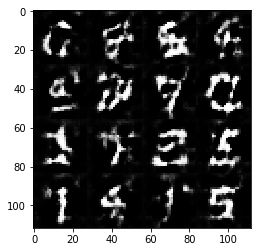

Epoch 1/2... Discriminator Loss: 1.5511... Generator Loss: 0.3299
Epoch 1/2... Discriminator Loss: 0.6675... Generator Loss: 1.4608
Epoch 1/2... Discriminator Loss: 0.8609... Generator Loss: 2.1315
Epoch 1/2... Discriminator Loss: 0.7266... Generator Loss: 1.4834
Epoch 1/2... Discriminator Loss: 1.0328... Generator Loss: 0.7071
Epoch 1/2... Discriminator Loss: 1.0809... Generator Loss: 0.6095
Epoch 1/2... Discriminator Loss: 0.6483... Generator Loss: 1.8248
Epoch 1/2... Discriminator Loss: 0.8982... Generator Loss: 0.7668
Epoch 1/2... Discriminator Loss: 1.2298... Generator Loss: 2.7992
Epoch 1/2... Discriminator Loss: 0.6435... Generator Loss: 1.4936


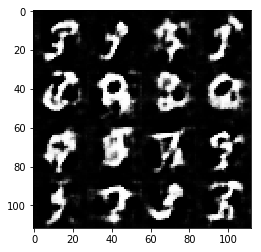

Epoch 1/2... Discriminator Loss: 0.5572... Generator Loss: 1.2920
Epoch 1/2... Discriminator Loss: 1.0327... Generator Loss: 0.7056
Epoch 1/2... Discriminator Loss: 0.9241... Generator Loss: 0.7104
Epoch 1/2... Discriminator Loss: 0.9956... Generator Loss: 0.7015
Epoch 1/2... Discriminator Loss: 0.8583... Generator Loss: 0.8193
Epoch 1/2... Discriminator Loss: 0.7450... Generator Loss: 1.3768
Epoch 1/2... Discriminator Loss: 1.2485... Generator Loss: 3.0797
Epoch 1/2... Discriminator Loss: 0.7566... Generator Loss: 1.2100
Epoch 1/2... Discriminator Loss: 0.8479... Generator Loss: 0.9344
Epoch 1/2... Discriminator Loss: 0.8033... Generator Loss: 0.9227


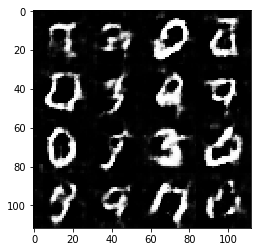

Epoch 1/2... Discriminator Loss: 0.8899... Generator Loss: 0.7660
Epoch 1/2... Discriminator Loss: 0.7192... Generator Loss: 1.1601
Epoch 1/2... Discriminator Loss: 0.9892... Generator Loss: 0.6447
Epoch 1/2... Discriminator Loss: 0.8486... Generator Loss: 0.9127
Epoch 1/2... Discriminator Loss: 0.8836... Generator Loss: 1.8681
Epoch 1/2... Discriminator Loss: 1.0941... Generator Loss: 1.9714
Epoch 1/2... Discriminator Loss: 0.8023... Generator Loss: 1.0583
Epoch 1/2... Discriminator Loss: 0.8632... Generator Loss: 1.8345
Epoch 1/2... Discriminator Loss: 0.8240... Generator Loss: 1.0102
Epoch 1/2... Discriminator Loss: 0.9747... Generator Loss: 1.8262


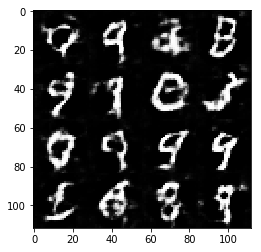

Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 0.4468
Epoch 1/2... Discriminator Loss: 0.7367... Generator Loss: 1.3493
Epoch 1/2... Discriminator Loss: 0.9887... Generator Loss: 0.6654
Epoch 1/2... Discriminator Loss: 0.8497... Generator Loss: 1.8608
Epoch 1/2... Discriminator Loss: 0.6807... Generator Loss: 1.4195
Epoch 1/2... Discriminator Loss: 0.8482... Generator Loss: 0.9868
Epoch 1/2... Discriminator Loss: 1.1854... Generator Loss: 0.5144
Epoch 1/2... Discriminator Loss: 0.7139... Generator Loss: 1.4101
Epoch 1/2... Discriminator Loss: 1.6729... Generator Loss: 0.2730
Epoch 1/2... Discriminator Loss: 0.8709... Generator Loss: 1.4493


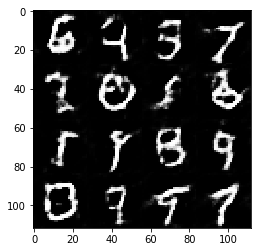

Epoch 1/2... Discriminator Loss: 0.8052... Generator Loss: 2.0093
Epoch 1/2... Discriminator Loss: 0.9520... Generator Loss: 0.6790
Epoch 1/2... Discriminator Loss: 0.6272... Generator Loss: 1.6219
Epoch 1/2... Discriminator Loss: 0.7637... Generator Loss: 1.1107
Epoch 1/2... Discriminator Loss: 0.9612... Generator Loss: 0.7255
Epoch 1/2... Discriminator Loss: 0.9763... Generator Loss: 0.6457
Epoch 1/2... Discriminator Loss: 0.9970... Generator Loss: 2.0293
Epoch 1/2... Discriminator Loss: 0.7808... Generator Loss: 1.1805
Epoch 1/2... Discriminator Loss: 0.9193... Generator Loss: 1.5239
Epoch 1/2... Discriminator Loss: 1.0354... Generator Loss: 0.6369


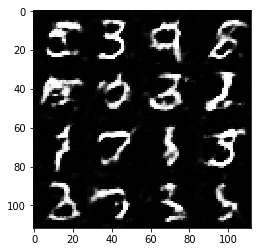

Epoch 1/2... Discriminator Loss: 1.1265... Generator Loss: 2.5627
Epoch 1/2... Discriminator Loss: 0.7199... Generator Loss: 1.7710
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 2.0901
Epoch 2/2... Discriminator Loss: 0.8032... Generator Loss: 1.0903
Epoch 2/2... Discriminator Loss: 1.0175... Generator Loss: 0.6080
Epoch 2/2... Discriminator Loss: 0.7864... Generator Loss: 1.5714
Epoch 2/2... Discriminator Loss: 0.7983... Generator Loss: 0.8629
Epoch 2/2... Discriminator Loss: 0.6233... Generator Loss: 1.6635
Epoch 2/2... Discriminator Loss: 0.8741... Generator Loss: 0.8187
Epoch 2/2... Discriminator Loss: 0.8479... Generator Loss: 1.0946


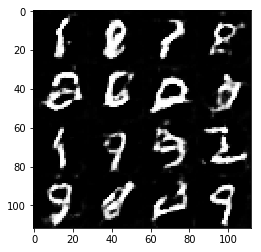

Epoch 2/2... Discriminator Loss: 0.8926... Generator Loss: 0.9132
Epoch 2/2... Discriminator Loss: 0.8155... Generator Loss: 1.4009
Epoch 2/2... Discriminator Loss: 1.0988... Generator Loss: 0.5596
Epoch 2/2... Discriminator Loss: 0.7970... Generator Loss: 0.8320
Epoch 2/2... Discriminator Loss: 0.8116... Generator Loss: 0.8336
Epoch 2/2... Discriminator Loss: 0.7124... Generator Loss: 1.4376
Epoch 2/2... Discriminator Loss: 0.8182... Generator Loss: 0.8798
Epoch 2/2... Discriminator Loss: 0.8459... Generator Loss: 0.9339
Epoch 2/2... Discriminator Loss: 1.2534... Generator Loss: 0.4555
Epoch 2/2... Discriminator Loss: 1.0238... Generator Loss: 0.6916


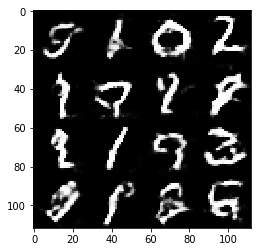

Epoch 2/2... Discriminator Loss: 0.6585... Generator Loss: 1.3471
Epoch 2/2... Discriminator Loss: 0.7486... Generator Loss: 0.9913
Epoch 2/2... Discriminator Loss: 0.9158... Generator Loss: 0.7808
Epoch 2/2... Discriminator Loss: 0.6208... Generator Loss: 1.3011
Epoch 2/2... Discriminator Loss: 0.8246... Generator Loss: 0.8340
Epoch 2/2... Discriminator Loss: 0.7149... Generator Loss: 1.6304
Epoch 2/2... Discriminator Loss: 0.8166... Generator Loss: 0.8103
Epoch 2/2... Discriminator Loss: 0.7830... Generator Loss: 0.8903
Epoch 2/2... Discriminator Loss: 0.7960... Generator Loss: 0.8024
Epoch 2/2... Discriminator Loss: 0.7299... Generator Loss: 2.3540


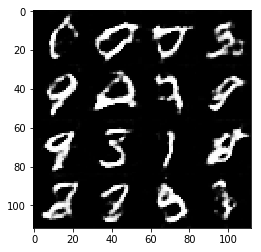

Epoch 2/2... Discriminator Loss: 0.6385... Generator Loss: 1.2862
Epoch 2/2... Discriminator Loss: 0.7032... Generator Loss: 1.1299
Epoch 2/2... Discriminator Loss: 1.8130... Generator Loss: 3.2628
Epoch 2/2... Discriminator Loss: 0.8197... Generator Loss: 1.1053
Epoch 2/2... Discriminator Loss: 0.7441... Generator Loss: 1.0210
Epoch 2/2... Discriminator Loss: 0.6383... Generator Loss: 1.1579
Epoch 2/2... Discriminator Loss: 0.5683... Generator Loss: 1.3653
Epoch 2/2... Discriminator Loss: 0.9210... Generator Loss: 0.7019
Epoch 2/2... Discriminator Loss: 1.0809... Generator Loss: 0.5832
Epoch 2/2... Discriminator Loss: 1.0679... Generator Loss: 0.5533


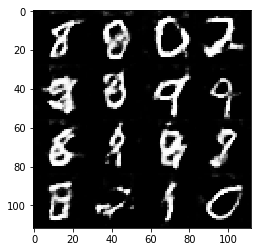

Epoch 2/2... Discriminator Loss: 1.2151... Generator Loss: 0.5806
Epoch 2/2... Discriminator Loss: 0.8123... Generator Loss: 0.9214
Epoch 2/2... Discriminator Loss: 0.7254... Generator Loss: 1.0164
Epoch 2/2... Discriminator Loss: 1.0149... Generator Loss: 2.5913
Epoch 2/2... Discriminator Loss: 0.5480... Generator Loss: 1.5942
Epoch 2/2... Discriminator Loss: 0.7252... Generator Loss: 0.9847
Epoch 2/2... Discriminator Loss: 0.5903... Generator Loss: 1.2297
Epoch 2/2... Discriminator Loss: 0.5435... Generator Loss: 1.5449
Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 0.7440
Epoch 2/2... Discriminator Loss: 0.9750... Generator Loss: 0.6716


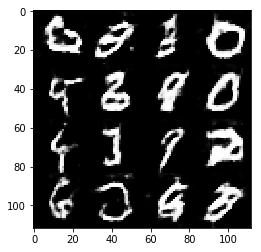

Epoch 2/2... Discriminator Loss: 1.4600... Generator Loss: 3.1362
Epoch 2/2... Discriminator Loss: 0.5632... Generator Loss: 1.2800
Epoch 2/2... Discriminator Loss: 0.8241... Generator Loss: 0.8652
Epoch 2/2... Discriminator Loss: 0.8705... Generator Loss: 0.9711
Epoch 2/2... Discriminator Loss: 0.6756... Generator Loss: 1.1276
Epoch 2/2... Discriminator Loss: 0.5606... Generator Loss: 1.2885
Epoch 2/2... Discriminator Loss: 0.7752... Generator Loss: 0.8232
Epoch 2/2... Discriminator Loss: 0.5357... Generator Loss: 1.6900
Epoch 2/2... Discriminator Loss: 1.0053... Generator Loss: 2.0563
Epoch 2/2... Discriminator Loss: 4.4971... Generator Loss: 6.2602


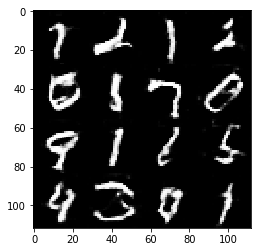

Epoch 2/2... Discriminator Loss: 0.7873... Generator Loss: 1.8490
Epoch 2/2... Discriminator Loss: 0.7728... Generator Loss: 1.0894
Epoch 2/2... Discriminator Loss: 0.8720... Generator Loss: 0.7431
Epoch 2/2... Discriminator Loss: 1.7581... Generator Loss: 0.2279
Epoch 2/2... Discriminator Loss: 0.6812... Generator Loss: 1.0360
Epoch 2/2... Discriminator Loss: 0.7624... Generator Loss: 0.8735
Epoch 2/2... Discriminator Loss: 0.6794... Generator Loss: 1.5806
Epoch 2/2... Discriminator Loss: 0.8225... Generator Loss: 0.9864
Epoch 2/2... Discriminator Loss: 1.1997... Generator Loss: 3.0390
Epoch 2/2... Discriminator Loss: 0.7267... Generator Loss: 0.9649


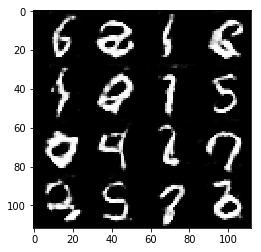

Epoch 2/2... Discriminator Loss: 0.8533... Generator Loss: 0.9412
Epoch 2/2... Discriminator Loss: 0.9006... Generator Loss: 0.6977
Epoch 2/2... Discriminator Loss: 0.6973... Generator Loss: 1.0820
Epoch 2/2... Discriminator Loss: 0.6427... Generator Loss: 1.0691
Epoch 2/2... Discriminator Loss: 0.9123... Generator Loss: 0.6937
Epoch 2/2... Discriminator Loss: 0.6866... Generator Loss: 2.1858
Epoch 2/2... Discriminator Loss: 0.9408... Generator Loss: 0.6569
Epoch 2/2... Discriminator Loss: 0.6072... Generator Loss: 1.5475
Epoch 2/2... Discriminator Loss: 1.7695... Generator Loss: 0.3145
Epoch 2/2... Discriminator Loss: 0.7631... Generator Loss: 0.9186


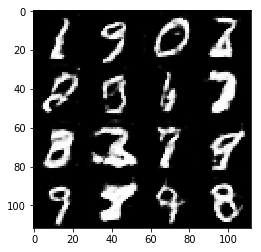

Epoch 2/2... Discriminator Loss: 0.8912... Generator Loss: 0.7725
Epoch 2/2... Discriminator Loss: 0.8347... Generator Loss: 1.9035
Epoch 2/2... Discriminator Loss: 0.6329... Generator Loss: 1.1211
Epoch 2/2... Discriminator Loss: 0.7170... Generator Loss: 0.9352
Epoch 2/2... Discriminator Loss: 1.7289... Generator Loss: 0.3082
Epoch 2/2... Discriminator Loss: 0.6313... Generator Loss: 1.7995
Epoch 2/2... Discriminator Loss: 0.9829... Generator Loss: 0.6916
Epoch 2/2... Discriminator Loss: 0.8491... Generator Loss: 0.8456
Epoch 2/2... Discriminator Loss: 0.7689... Generator Loss: 1.1041
Epoch 2/2... Discriminator Loss: 0.6414... Generator Loss: 1.0741


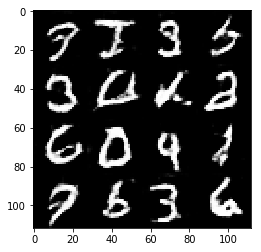

Epoch 2/2... Discriminator Loss: 0.5052... Generator Loss: 1.2941
Epoch 2/2... Discriminator Loss: 0.9835... Generator Loss: 0.5929
Epoch 2/2... Discriminator Loss: 0.5727... Generator Loss: 1.4809
Epoch 2/2... Discriminator Loss: 0.6057... Generator Loss: 1.1528
Epoch 2/2... Discriminator Loss: 0.7896... Generator Loss: 1.3159
Epoch 2/2... Discriminator Loss: 0.6381... Generator Loss: 1.1399
Epoch 2/2... Discriminator Loss: 0.6603... Generator Loss: 1.0982


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2846... Generator Loss: 3.5718
Epoch 1/1... Discriminator Loss: 0.1340... Generator Loss: 2.5606
Epoch 1/1... Discriminator Loss: 0.2740... Generator Loss: 2.0217
Epoch 1/1... Discriminator Loss: 0.1233... Generator Loss: 3.3003
Epoch 1/1... Discriminator Loss: 0.6320... Generator Loss: 1.4895
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.7657... Generator Loss: 0.2975
Epoch 1/1... Discriminator Loss: 1.5767... Generator Loss: 0.4637


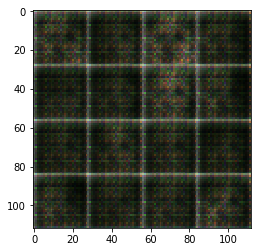

Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 1.1331
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 1.2585
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 1.7053... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 1.0237
Epoch 1/1... Discriminator Loss: 1.5190... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.5687
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.7705


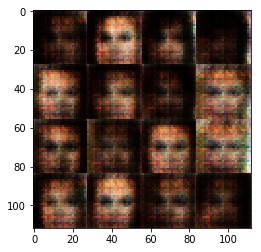

Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 1.4650
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 1.0474
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.5277
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 1.0233
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.4899


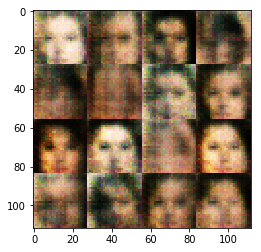

Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.9347
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 1.1292
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 1.1959
Epoch 1/1... Discriminator Loss: 1.6679... Generator Loss: 2.6943
Epoch 1/1... Discriminator Loss: 1.7111... Generator Loss: 0.4730
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.9151


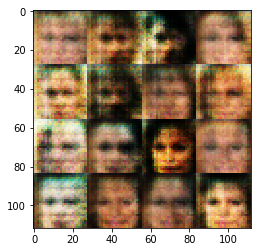

Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.5435
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 1.3848
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 1.0019
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.7548


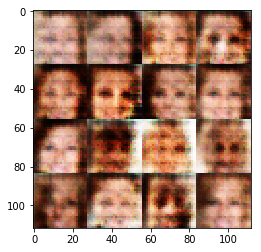

Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 1.9863
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.5178
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.8894


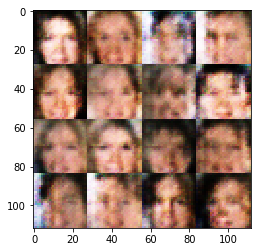

Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 1.0634
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.5618
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.6910


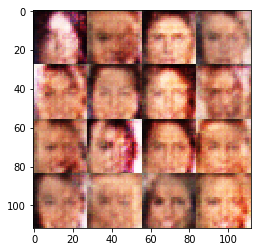

Epoch 1/1... Discriminator Loss: 1.5231... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 1.1562
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.5491
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.9073


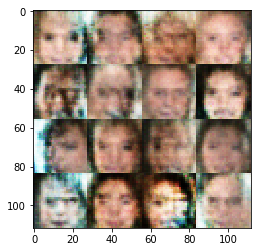

Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 1.0250
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.1004
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 1.0349
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 1.2973
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.7918


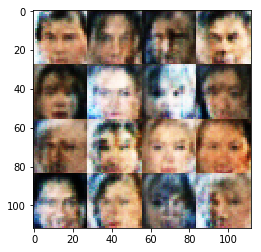

Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.5906
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 1.0397
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.8766


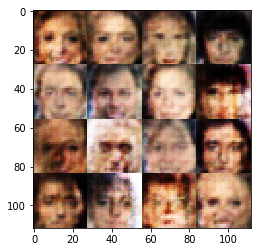

Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.4851
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.9652
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.6139


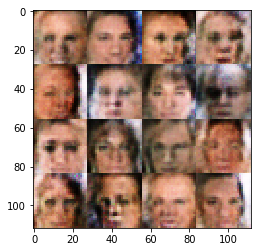

Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 1.0356
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.8292


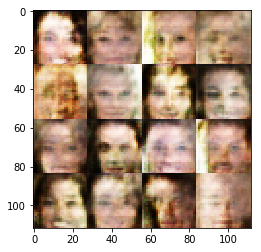

Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 1.0149
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.7810


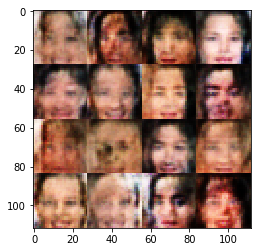

Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 1.1301
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.5099
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.8789


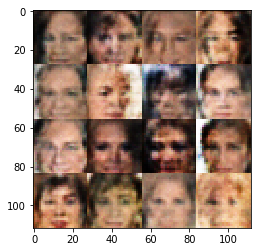

Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.5256
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 1.0476
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 1.0153


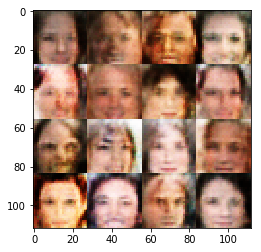

Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.6050
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 1.1154
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 1.2516
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 1.0177


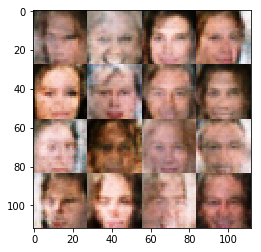

Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.4810
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.5080
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.5046
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.6484


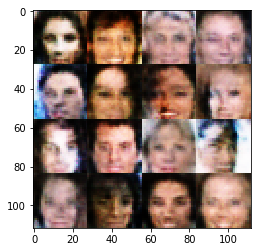

Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.5061
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.0010
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 0.8299


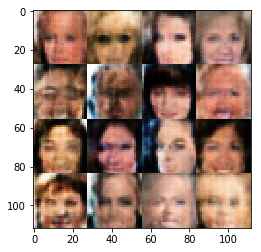

Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 1.0243
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.7598


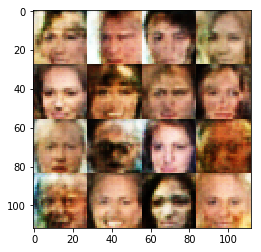

Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.5763
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 0.9929... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 1.2843
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 0.8505


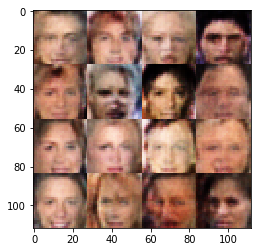

Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.5330
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 0.8376... Generator Loss: 1.1287
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.4587
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.5283
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.6633


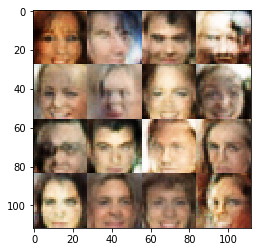

Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.4884
Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 1.1239
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 0.9358


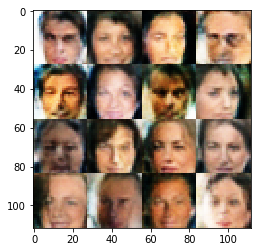

Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 0.8125... Generator Loss: 1.0857
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.9015


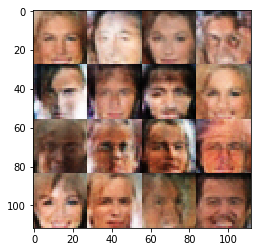

Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.5976
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.3903
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.0940... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 0.9250


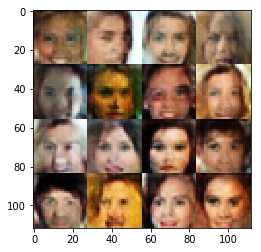

Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.4969
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.5644
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.5116
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.4860
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.5477


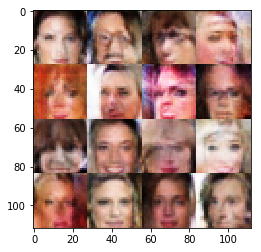

Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.3812
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 0.9439
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.4597
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.5325
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.5992


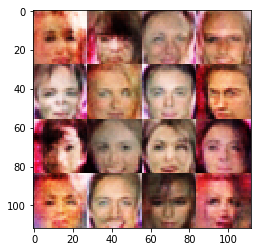

Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.4950
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 0.8535
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 0.8920... Generator Loss: 1.0655
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 1.1197


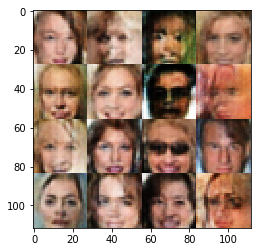

Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 1.0707
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.7810


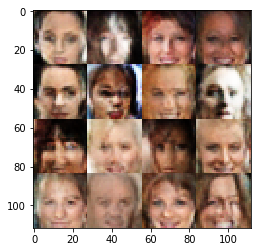

Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.5571... Generator Loss: 0.3566
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 0.9213... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.4950
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.6601


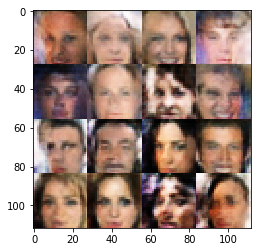

Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 1.0280
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.5581
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 0.9750
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.4716


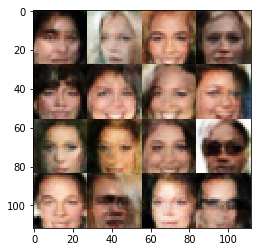

Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 0.9013
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 0.8929... Generator Loss: 1.2991
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.5092


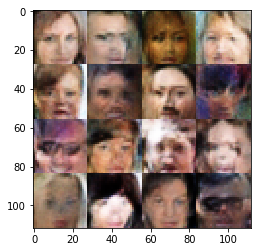

Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.4572
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.5182
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.8122


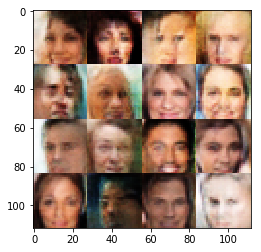

Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.9914
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.0245... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.5932


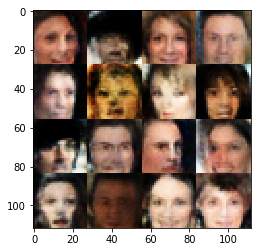

Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.5465
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 1.0919
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.6608


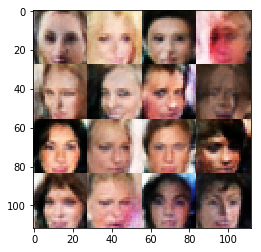

Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.5274
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 1.0357
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 0.9006... Generator Loss: 0.9872


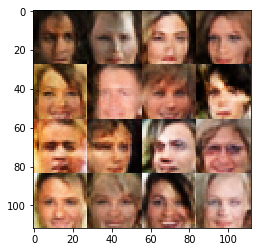

Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.5480
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.5404
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.4357
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.5014


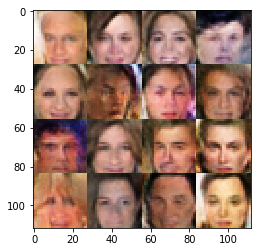

Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.4899
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.4974
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.5549
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.6077


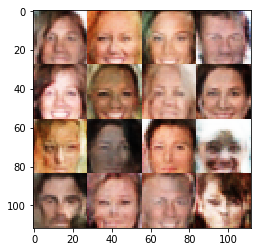

Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 0.9316
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.5091
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 0.8485


In [ ]:
batch_size = 40
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.